# Image Classification with Tensorflow
---

This notebook contains some simple experimentation using tensorflow for image classification tasks. The CIFAR-10 dataset was used which contains 10 classes: cat, dog, deer, horse, frog, car, truck, train, aeroplane and ship. 

Some of the contents of this notebook were submitted for a university assignment but it has been altered to act as a demonstration of some of my experience and as a demonstration. As I intend to use it as a tutorial, it is still a work in progress. 


Install Cudatoolkit version 10.1.168 from the [NVIDIA Cuda Archive](https://developer.nvidia.com/cuda-toolkit-archive). Although, at the time 10.2 was available, the tensorflow version of tensorflow-gpu available on Pypi was 2.1.0 which requires Cuda 10.1. Select custom/advanced installation option. Select the items under the heading `CUDA`, `Development` and `Runtime`. I think that is all that is required but feel free to add any of the other items. If your GPU drivers are newer, don't reinstall the older ones it recommends. If you select the Visual Studio integration (not required for this notebook): you should have preinstalled Visual Studio. I found the best way is to install Visual Studio 2019 (go for the Community Edition which is free), and install the Desktop C++ developement tools. You could also install all of the other compilers/C++ buildtools X86_X64 e.g. 2015 and 2017 which can be useful for compiling python libraries from source.

#### Windows 10:

Then use the following commands in anaconda prompt:

`conda create -n tf-gpu python==3.7.5 ipykernel numpy scipy scikit-learn matplotlib pillow cudatoolkit==10.1.168 cudnn`

`conda activate tf-gpu`

`pip install tensorflow-gpu==2.1.0`

`python -m ipykernel install --user --name tf-gpu --display-name Tensorflow-GPU-2`

I have also used openCV. On windows I had to download the whl file from:

https://www.lfd.uci.edu/~gohlke/pythonlibs/

and install using pip:

cd "download location"

`pip install "whl file"`

replace "download location" and "whl file" appropriately

#### Ubuntu 18.04:

On linux I just had to install Cudtoolkit 10.1.168 and then the following commands in anaconda prompt (Note the addition of `tensorflow-gpu` on this line):

`conda create -n tf-gpu python==3.7.5 ipykernel numpy scipy scikit-learn matplotlib pillow cudatoolkit==10.1.168 cudnn tensorflow-gpu==2.1.0`

`conda activate tf-gpu`

`pip install opencv-python`

`python -m ipykernel install --user --name tf-gpu --display-name Tensorflow-GPU-2`

In [1]:
print(__import__('sys').version)
!conda list -n tf-gpu

3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]
# packages in environment at C:\__Dev__\Anaconda3\envs\tf-gpu:
#
# Name                    Version                   Build  Channel
absl-py                   0.9.0                    pypi_0    pypi
astor                     0.8.1                    pypi_0    pypi
backcall                  0.1.0                    py37_0  
blas                      1.0                         mkl  
ca-certificates           2020.1.1                      0  
cachetools                4.1.0                    pypi_0    pypi
certifi                   2020.4.5.1               py37_0  
chardet                   3.0.4                    pypi_0    pypi
colorama                  0.4.3                      py_0  
cudatoolkit               10.1.168                      0  
cudnn                     7.6.5                cuda10.1_0  
cycler                    0.10.0                   py37_0  
decorator                 4.4.2                      py_0

Please load these into memory

In [2]:
######################################################################################
#                                    Imports                                         #
######################################################################################

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, \
BatchNormalization, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta, Adagrad
from tensorflow.keras import Model, regularizers
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

#from tensorflow import set_random_seed
import math
import cv2
import glob
import os.path
import pickle
%pylab inline

seterr(divide='ignore', invalid='ignore')

Populating the interactive namespace from numpy and matplotlib


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
%load_ext tensorboard

# Training

##### This part of the notebook holds all of the training functions etc.. The cells which contain functions should be loaded into memory as they may be used later

In [4]:
def data_loader(name, normalize=True, categorical=True, n_class=10,  resize=False, res_shape=(128, 128)):
    '''
    Funtion for loading the input dataset:
    Input:
            name: name of the dataset
            normalize: boolean variable for normalsing the dataset
            categorical: boolean variable for converting the lables to categorical
            NB_CLASSES: number of classes in the input dataset
            resize: boolean variable for resizing the images of the input dataset to any size
            res_shape: a tuple with the desired resizing shape

    Output: a tuple with the trainning and testing images and lables
    '''
    if name=='CIFAR10':
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        print(x_train.shape, 'training samples')
        print(x_test.shape, 'test samples')

    else:
        # you can add your own dataset here
        raise ValueError('Not supported dataset')

    # Normalization step
    if (normalize):
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

    # convert to categorical
    if (categorical):
        y_train = to_categorical(y_train, n_class)
        y_test = to_categorical(y_test, n_class)

    # Resize training images
    if(resize):
        img_rows= res_shape[0]
        img_cols= res_shape[1]
        x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train])
        x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test])

    return (x_train, y_train, x_test, y_test)

In [5]:
def train_model(x_train, y_train, x_test, y_test, model, optimizer_opt={}, fit_opt={}):
    '''
    Funtion for training the CNN model:
    Input:
            X_train: training dataset images
            Y_train: training dataset classes/labels
            model: Keras model
            optimizer_opt: a dictionary with optimization parameters
            fit_opt: a dictionary with fitting parameters

    Output: the trained model
    '''
    
    opt = optimizer_opt.get('OPT', 'Adam')
    loss = optimizer_opt.get('loss', 'categorical_crossentropy')
    metrics = optimizer_opt.get('metrics', ['accuracy'])
    just_compile = optimizer_opt.get('just_compile', False)
    
    if just_compile:
        model.compile(optimizer=opt, loss=loss,  metrics=metrics)
        return model

    model.compile(optimizer=opt, loss=loss,  metrics=metrics)
    BATCH_SIZE = fit_opt.get('BATCH_SIZE', 128)
    NB_EPOCH = fit_opt.get('NB_EPOCH', 40)
    VERBOSE = fit_opt.get('VERBOSE', 1)
    IMGEN = fit_opt.get('IMGEN', None)
    
    # Allows one to revert back to better weights
    checkpointer = ModelCheckpoint(filepath="best_weights.h5", 
                                   monitor = 'val_acc',
                                   verbose=1, 
                                   save_best_only=True)
    
    # Reduces learning rate - I experimented with this a bit.
    # Although, perhaps not really required when using Adam, it did
    # seem to speed up convergence
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    
    ###################
    # train the model #
    ###################
    
    if IMGEN is not None: # Uses image augmentation
        model.fit_generator(
                            IMGEN.flow(x_train, y_train, batch_size=BATCH_SIZE),
                            steps_per_epoch=len(x_train) // BATCH_SIZE, epochs=NB_EPOCH,
                            verbose=VERBOSE,
                            validation_data=(x_test, y_test),
                            callbacks=[reduce_lr, checkpointer],
                            )
        
    else: # No augmentation
        model.fit(
                    x_train,
                    y_train,
                    batch_size=BATCH_SIZE, 
                    epochs=NB_EPOCH, 
                    verbose=VERBOSE,
                    validation_data=(x_test, y_test)
                    )
        
    # update history
    model.complete_history['val_acc'].extend(model.history.history['val_acc'])
    model.complete_history['acc'].extend(model.history.history['acc'])
    model.complete_history['val_loss'].extend(model.history.history['val_loss'])
    model.complete_history['loss'].extend(model.history.history['loss'])

    # save the trained model (architecture, weights and training configuration)
    model.save('%s.h5' % model.name)  # creates an HDF5 file 'model.name.h5'

    return model
   

def eval_model(x_test, y_test, model, eval_opt={}):
    '''
    Funtion for evaluating the CNN trained model:
    Input:
            X_test: test dataset images
            Y_test: test dataset classes/labels
            model: Keras model
            eval_opt: a dictionary with evaluation parameters

    Output: the result of the evaluation as a score/accuracy
    '''
    
    BATCH_SIZE = eval_opt.get('BATCH_SIZE', 128)
    VERBOSE = eval_opt.get('VERBOSE', 1)
    
    # Checks if input size and image size match - then resizes if necessary
    if not np.allclose(x_test.shape[1:], model.input_shape[1:]):
        
        img_rows = model.input_shape[1]
        img_cols = model.input_shape[2]
        
        x_test = np.array([cv2.resize(img, (img_rows, img_cols)) for img in x_test])
        
    score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
        
    print('Test accuracy: %.3f' % score[1])
    return score


def dataGenerator(X, y, batch_size, augment=True, shape=(128, 128, 3)):
    '''
    A generator designed to be used with keras Model.fit_generator.
    
    Args:
        X - array-like, data/images, shape(n_images, n_rows, n_columns, n_channels)
        y - array-like, targets, 1 hot encoding, '''
    
    img_rows = shape[0]
    img_cols = shape[1]
    
    if augment:
        IMGEN = ImageDataGenerator(
                                   rotation_range=20, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   #brightness_range=[], 
                                   #shear_range=0.2, 
                                   zoom_range=[0.7, 1.2], 
                                   channel_shift_range=0.2, 
                                   fill_mode='nearest',
                                   horizontal_flip=True, 
                                   #vertical_flip=True,
                                   )
        IMGEN.fit(X)

        while 1:
            XR, yr = IMGEN.flow(X, y, batch_size).__next__()
            XR = np.array([cv2.resize(img, (img_rows, img_cols)) for img in XR])
            yield XR, yr
    
    else:
        
        while 1:
            i = 0
            while i + batch_size < len(X):
                XR = X[i: i + batch_size]
                yr = y[i: i + batch_size]
                XR = np.array([cv2.resize(img, (img_rows, img_cols)) for img in XR])
                i += batch_size
                yield XR, yr
        
        
def dump_pickle(fname, data):
    with open(os.path.normpath(fname), 'wb') as open_file:
        pickle.dump(data, open_file)
        

def load_pickle(fname):
    with open(os.path.normpath(fname), 'rb') as open_file:
        return pickle.load(open_file)

      
def plot_history(model, title_string='filename'):
    '''
    Plots the change in loss per epoch

    Input:
        model  - trained keras CNN class

    Output:
        Figure
    '''
    
    if 'val_acc' in model.complete_history:
        
        plt.figure()

        y1 = model.complete_history['val_acc']
        y2 = model.complete_history['acc']
        xdata = range(1, len(y1) + 1)

        plt.plot(xdata, y1, label='validation accuracy')

        plt.plot(xdata, y2, label='training accuracy')

        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        
        plt.title(title_string)

        plt.savefig(r'%s.png' % title_string)

        plt.legend()

        plt.show()
        
    if 'val_loss' in model.complete_history:
        
        plt.figure()
        
        y1 = model.complete_history['val_loss']
        y2 = model.complete_history['loss']
        xdata = range(1, len(y1) + 1)

        plt.plot(xdata, y1, label='validation loss')

        plt.plot(xdata, y2, label='training loss')

        plt.xlabel('epoch')
        plt.ylabel('loss')

        plt.title(title_string)

        plt.savefig(r'%s.png' % title_string)

        plt.legend()

        plt.show()


def imgen(X):
    '''
    Returns an instance of ImageDataGenerator
    '''
  
    IMGEN = ImageDataGenerator(
                               rotation_range=20, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               #brightness_range=[], 
                               #shear_range=0.2, 
                               zoom_range=[0.7, 1.2], 
                               channel_shift_range=0.2, 
                               fill_mode='nearest',
                               horizontal_flip=True, 
                               #vertical_flip=True,
                               #rescale=0.5,
                               )
    IMGEN.fit(X)
    
    return IMGEN
  

def save_model(model, fname):
    model.save(os.path.normpath('models/%s.h5' % fname))


def load_cnn(model_type):
    '''
    For loading CNN models
    
    Args:
        model_type - int,
        
    Returns:
        model      - either keras.Sequential or keras.Model 
        
    '''

    if model_type == 1:
        path = 'models/IMP1.h5'   
    elif model_type == 2:
        path = 'models/IMP2.h5'
    elif model_type == 3:
        path = 'models/MNET1.h5'
    elif model_type == 4:
        path = 'models/MNET2.h5'
    else:
        raise ValueError('Invalid model number')
        
    model = load_model(os.path.normpath(path))
    # this is the history of the model learning
    model.complete_history = load_pickle(os.path.normpath(path[:-3] + ' H'))

    return model

Below are some CNN architectures that have been built from scratch.

It was easy to find ones that perform well on the internet, some of these include:

https://www.tensorflow.org/tutorials/images/cnn

https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
    
it can be seen that they are often very similar.

In [6]:
######################################################################################
#                                    Model Definitions                               #
######################################################################################

def define_model(model_type='improved1', name='CNN_baseline', model_opt={}):
    '''
    Funtion for defining the CNN architecture:
    Input:
            name: name of the model, helpful when you have more than one architecture to choose from
            model_opt: a dictionary with the hyperparameters required to build a model

    Output: the built model
    '''
    
    IMG_CHANNELS = model_opt.get('IMG_CHANNELS', 3)
    IMG_ROWS = model_opt.get('IMG_ROWS', 32)
    IMG_COLS = model_opt.get('IMG_COLS', 32)
    bn_axis = model_opt.get('bn_axis', 3)
    NB_CLASSES = model_opt.get('NB_CLASSES', 10)
    weight_decay = 5e-5
        
    if model_type == 'improved1':
            
        weight_decay = 1e-4
        
        model = Sequential()
        
        model.add(Conv2D(
                         32, 
                         (3, 3),
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay), 
                         input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS),
                         ))
        model.add(Activation('elu'))
        
        model.add(Conv2D(
                         32,
                         (3,3),
                         padding='same', 
                         kernel_regularizer=regularizers.l2(weight_decay),
                         ))
        model.add(Activation('elu'))
        
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))

        model.add(Conv2D(
                         64,
                         (3,3),
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay),
                         ))
        model.add(Activation('elu'))
        
        model.add(Conv2D(
                         64, 
                         (3,3),
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay),
                         ))
        model.add(Activation('elu'))
        
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(
                         128, 
                         (3, 3),
                         padding='same',
                         kernel_regularizer=regularizers.l2(weight_decay),
                         ))
        model.add(Activation('elu'))
        
        model.add(Conv2D(
                         256,
                         (3,3), 
                         padding='same',
                         #strides=(2, 2),
                         kernel_regularizer=regularizers.l2(weight_decay),
                         ))
        model.add(Activation('elu'))
        
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))
        
        model.add(Flatten()) 
        model.add(Dense(NB_CLASSES))
        model.add(Activation('softmax'))
        
    else:

        raise ValueError('Not supported architecture')

    # I added this incase I wanted to interrupt training but keep training information
    # and the keras History object gets wiped every time you start training
    model.complete_history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
        
    return model

##### Here I trained the models

The data need to be loaded into memeory

In [7]:
X_train, Y_train, X_test, Y_test = data_loader('CIFAR10')

# This is an instance of ImagDataGenerator
IMGEN = imgen(X_train)

170500096/170498071 [==============================] - 31s 0us/step
(50000, 32, 32, 3) training samples
(10000, 32, 32, 3) test samples


#### You do not need to run the below cell unless training 

In [9]:
model = define_model(model_type='improved1', name='Improved CNN2')

model = train_model(
                    X_train, 
                    Y_train,
                    X_test,
                    Y_test, 
                    model, fit_opt={'NB_EPOCH':300,
                                     'IMGEN': IMGEN, 
                                     'BATCH_SIZE': 128},
                    optimizer_opt={'OPT': Adam()},
                    )

## MobileNet

The following cells were meant to demonstrate the potential of transfer learning. MobileNets are CNNs pretrained for classification and are available through tensorflow. They have a couple of advantages: they have been trained on images from ImageNet, which is a very large dataset, furthermore they have had the advantage of being trained with state-of-the-art hardware. Transfer learning allows us to exploit these advantages. We are able to use MobileNets because the classes in the CIFAR-10 dataset are included in ImageNet and, therefore, MobileNets have already learned many of the useful features for the CIFAR-10 classification problem.

Transfer learning is implemented by simply obtaining a pretrained CNN and retraining some its final few layers. This could be just the fully connected layers or further back, including some convolutional layers too. 

https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet

In [7]:
def create_MobileNet(output_only=True):
    '''
    Loads an instance of MobileNet and prepares it for use
    
    Args:
        output_only - Boolean, True if only output layer is to be trained
                      if False, will return model with last convolution with
                      training enabled and extra dropout layer added
    '''
    n_classes = 10

    input_tensor = Input(shape=(128, 128, 3))

    base_model = MobileNet(
                           weights='imagenet',
                           input_shape=(128, 128, 3),
                           include_top=False,
                           input_tensor=input_tensor,
                           #alpha=0.50,
                           pooling='max',
                           #depth_multiplier=0.5,
                           )
    
    x = base_model.output
    
    # only train output layer
    if output_only:
        weight_decay = 1e-4
        for layer in base_model.layers:
            layer.trainable = False
            
    # retrain last convolutional layer
    else:
        weight_decay = 1e-4
        for layer in base_model.layers[:-1]:
            layer.trainable = False
            
            x = Dropout(0.3)(base_model.output)
            
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.summary()

    model.complete_history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
    
    return model

In [13]:
# Load into memory

X_test128 = np.array([cv2.resize(img, (128, 128)) for img in X_test])

#### You do not need to run the below cell unless training MobileNet

Two MobileNets were retrained using transfer learning, MNET1 and MNET2.

MNET1 was locked as to prevent further weight adjustment. However, an additional dense layer with softmax activation function was added to serve as the output which was a vector of size 10. The purpose of doing this is to see what happens if we only trained the final fully connected layer.

MNET2 was trained in the same way except that only the layers which come before the last convolutional layer were locked to allow the last convolutional layer to be trained along with and subsequent fully connected layers.



In [347]:
model = create_MobileNet(1)


BATCH_SIZE = 128
NB_EPOCH = 100
VERBOSE = True

# saves best weights obtained
checkpointer = ModelCheckpoint(filepath="best_weights.h5", 
                                   monitor = 'val_acc',
                                   verbose=1, 
                                   save_best_only=True)

# I used this to speed up training a bit 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-7)

TRAIN_STEPS = len(X_train) // BATCH_SIZE
VAL_STEPS = len(X_test128) // BATCH_SIZE

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
                    dataGenerator(X_train, Y_train, batch_size=BATCH_SIZE, augment=True),
                    steps_per_epoch=TRAIN_STEPS, 
                    epochs=NB_EPOCH,
                    verbose=VERBOSE,
                    validation_data=(X_test128, Y_test),
                    callbacks=[reduce_lr, checkpointer],
                    )

# Evaluation

Models can be loaded with the load_cnn() function. To load a specific model use an int as an arguement as follows:

1 - Improved model without image augmentation 

2 - Improved model with image augmentation

3 - MobileNet model after only training output layer

4 - MobileNet model after training output and last convolutional layer

The learning history of the model can be plotted with this function. I only kept accuracy on the early models, which in hindsight was a mistake.

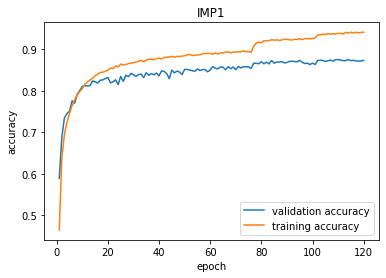

In [21]:
model = load_cnn(1)
plot_history(model, 'IMP1')

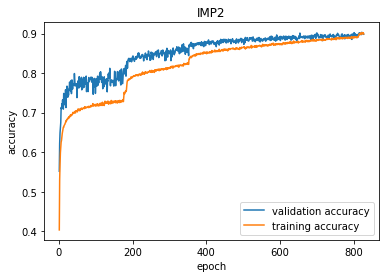

In [22]:
model = load_cnn(2)
plot_history(model, 'IMP2')

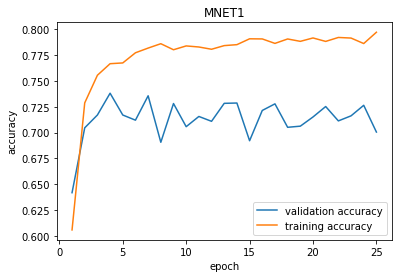

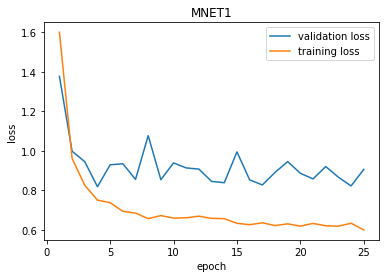

In [23]:
model = load_cnn(3)
plot_history(model, 'MNET1')

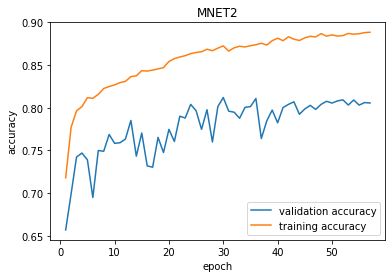

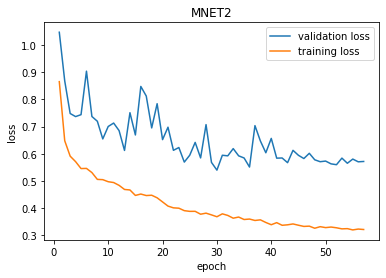

In [24]:
model = load_cnn(4)
plot_history(model, 'MNET2')

You can see the validation performance of each model by changing the int arguement in the 'load_cnn()' function and running the below cell.

In [17]:
#eval_model(X_test, Y_test, model)

model = load_cnn(1)

if type(model) == Sequential:
    eval_model(X_test, Y_test, model)

elif type(model) == Model:
    eval_model(X_test128, Y_test, model)

# Testing

In [9]:
from PIL import Image, ImageFilter
from sklearn.metrics import confusion_matrix
import seaborn as sn
from pandas import DataFrame

In [10]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# For converting between labels and 1 hot encoding

translator = {}

for i in range(10):
    
    one_hot = np.zeros(10)
    one_hot[i] = 1
    translator[repr(one_hot)] = classes[i]

In [11]:
def resize_test_images(classes=classes, size=(32, 32), save=1, blur=1):
    '''
    This is a function that opens the images I collected and resizes them.
    It then either saves the images or passes them as output
    
    Args:
        classes - list, classes in the dataset
        size    - tuple, target size of images
        save    - boolean, if 0 images are not saved, saved otherwise
    
    Returns:
        saves images to disk otherwise returns dict of lists of PIL.Image objects 
        where name of classes in string form in the key
        
        '''


    images = {}
             
    for c in classes:
        
        images[c] = []
        
        path = r'test set/%s/image' % c
        
        for i in range(20):
            
            try:
                ext = '.jpg'
                fname = '%s%d%s' % (path, i, ext)
                image = Image.open(os.path.normpath(fname)).convert('RGB')
                
            except:
                ext = '.png'
                fname = '%s%d%s' % (path, i, ext)
                image = Image.open(os.path.normpath(fname)).convert('RGB')
                
            if blur:
                # apply gaussian blur
                kernel_size = image.size[0] // 75
                image = image.filter(ImageFilter.GaussianBlur(radius=kernel_size))
                
            fname = r'%s%d_resized%s' % (path, i, '.png') 
            image = image.resize(size)
            
            if save:
                image.save(fname, "PNG", )
            
            images[c].append(image)
                
    return images

In [12]:
def load_test_set(classes=classes, from_orig=0, save=0, blur=1):
    '''
    Loads pre-resized images, or loads and resizes original images
    
    Returns:
        dic of lists of PIL.Image objects where label of class is the
        key
    
    '''

    if from_orig:
        images = resize_test_images(save=save, blur=blur)

    else:
        images = {c: [] for c in classes}

        for c in classes:
            path = r'test set/%s/image' % c

            for i in range(20):
                fname = r'%s%d_resized%s' % (path, i, '.png') 
                image = Image.open(os.path.normpath(fname)).convert('RGB')
                image = np.asarray(image)                
                images[c].append(image)
    
    return images

In [13]:
def construct_XYTest(images, classes=classes, norm=True):
    '''
    Converts custom image test set into numpy arrays
    with labels
    
    Args:
        images  - dict of lists of images where label of class is 
                  the key
        classes - list of strings, class labels 
    '''
    X = []
    y = []
    
    for i, c in enumerate(classes):

        one_hot = np.zeros(10)
        one_hot[i] = 1
        
        for image in images[c]:
            
            image = np.asarray(image)
            
            X.append(image)
            y.append(one_hot)
    
    idx = np.random.permutation(len(X))
    
    X = np.array(X)[idx] / 255
    y = np.array(y)[idx]
    
    return X, y

In [14]:
def get_class_indices(y, classes=classes, translator=translator):
    '''
    Returns all of the indices of each label in a set of labels
    organized into a dict where the string label is the key
    '''

    idx = {c:[] for c in classes}

    for c in classes:

        for i, target in enumerate(y):

            if c == translator[repr(target)]:

                idx[c].append(i)
                
    return idx
    

In [15]:
def random_sample_generator(X, idx, classes=classes):
    '''
    Creates a generator which will yield a random sample containing 1 of 
    each class.
    
    Args:
        X       - array-like, samples, shape(n_samples, n_rows, n_columns, n_channels)
        idx     - dict, of lists containing indices of each class in X where the class
                  label is the key
        classes - list, containing string representations of each class
    
    '''  
    n = len(idx[classes[0]])
    
    while 1:
        
        perm = np.random.permutation(n)
        i = 0
        
        while i < 10:
            
            row_ids = np.zeros(10, dtype=int)
            
            for c in classes:
                
                row_ids[i] = idx[c][perm[i]]

                i += 1
                
            yield X[row_ids] 

In [16]:
def display_random_images(X, idx, gen=random_sample_generator, classes=classes):
    
    '''
    A generator that produces a figure of a random sample containing 1 of each class
    
    Args:
        X       - array-like, samples, shape(n_samples, n_rows, n_columns, n_channels)
        idx     - dict, of lists containing indices of each class in X where the class
                  label is the key
        gen     - generator, returns a sample containing 1 of each class
        classes - list, containing string representations of each class
    '''
    
    gen = gen(X, idx)
    
    while 1:
        
        X = gen.__next__()
        
        plt.figure(figsize=(10, 5))

        plt.title('Random Sample of Test Set Images')

        for i in range(10): 

            plt.subplot(2, 5, i + 1)

            plt.imshow(X[i])
            plt.tick_params(
                            axis='both',    # changes apply to the x-axis
                            which='both',   # both major and minor ticks are affected
                            bottom=False,   # ticks along the bottom edge are off
                            top=False,
                            left=False,      # ticks along the bottom edge are off
                            right=False,     # ticks along the top edge are off
                            labelbottom=False,
                            labelleft=False,
                            ) 

            plt.xlabel(classes[i], fontsize=15)

        plt.subplots_adjust(hspace=0.15)

        plt.show()
        
        yield

In [17]:
def display_confusion(targets, predictions, classes=classes):
    '''
    Displays a confusion matrix. Takes in 1 hot encoding vectors
    as arguments
    '''
    
    t = targets.argmax(1) # convert 1 hot encoding into single integer representation
    p = predictions.argmax(1)
    
    matrix = confusion_matrix(t, p)
    
    df_cm = DataFrame(
                      matrix.T, 
                      index=classes,
                      columns=classes,
                      )
    
    plt.figure(figsize=(11,8))
    
    sn.heatmap(df_cm, annot=True)
    plt.xticks(rotation=45, fontsize=13)
    plt.yticks(rotation=0, fontsize=13)
    plt.xlabel('actual class', fontsize=13)
    plt.ylabel('predicted class', fontsize=13)
    
    plt.show()

In [18]:
def make_predictions(model, Xtest, ytest):
    '''
    Had to make this function to handle different input sizes of different
    networks
    '''
    
    if type(model) == Sequential:
        
        return model.predict(Xtest)
    else:
        return model.predict_generator(dataGenerator(
                                                     Xtest,
                                                     ytest, 
                                                     batch_size=1,
                                                     augment=False), 
                                                     steps=len(Xtest),
                                                     verbose=True
                                                     )


In [29]:
def get_mistake_indices(targets, predictions, trans=translator, classes=classes):
    '''
    Returns indices and labels of misclassifications
    
    '''
    # prediction 1 hot encoding will be 'messy' i.e. not just zeros and a one
    # but a variety of numbers in between.
    # we need to get the highest probability to be one and rest zeros
    t = targets.argmax(1) # convert 1 hot encoding into single integer representation
    p = predictions.argmax(1)
    idx = []
    labels = []

    for i in range(len(targets)):
        if t[i] != p[i]:
        
            idx.append(i)
            
            # Turn back into 1 hot encoding but with no longer 'messy'
            true = to_categorical(t[i], 10, dtype=float)
            false = to_categorical(p[i], 10, dtype=float)
            
            labels.append((trans[repr(true)], trans[repr(false)])) # tuple of strings
                                                                   # true label and pred label
        
    # A naive way to get labels into order    
    labels_idx = []
    
    for c1 in classes:
        for c2 in classes:
            for i, label in enumerate(labels):
                if label[0] == c1:
                    if label[1] == c2:
                        labels_idx.append(i)
                
    idx = np.array(idx)[labels_idx]
    labels = np.array(labels)[labels_idx]
                
    return idx, labels

In [30]:
def display_mistakes(X, labels, n_cols=7):
    '''
    An image generator for visualizing misclassified samples
    
    X      - array-like, misclassified samples
    labels - list, of tuples, (true, false-predict)
    '''   
    n_rows = math.ceil(len(labels) / n_cols)
    
    plt.figure(figsize=(18, 21))
        
    for i in range(len(X)):

        plt.subplot(n_rows, n_cols, i + 1)

        plt.imshow(X[i])
        
        plt.tick_params(
                        axis='both',    # changes apply to the x-axis
                        which='both',   # both major and minor ticks are affected
                        bottom=False,   # ticks along the bottom edge are off
                        top=False,
                        left=False,      # ticks along the bottom edge are off
                        right=False,     # ticks along the top edge are off
                        labelbottom=False,
                        labelleft=False,
                        ) 

        plt.title('%s misclassified as %s' % tuple(labels[i]), fontsize=10)
        
        plt.subplots_adjust(hspace=0.2, wspace=0.8)
        
    plt.show()


### Okay, here is where we'll start doing stuff...

I used this to display images

In [31]:
idx = get_class_indices(Y_test.astype(float))

cifar10_display = display_random_images(X_test, idx)

Below we can see a random sample of the images in the CIFAR-10 dataset.

Keep executing this cell to display more images

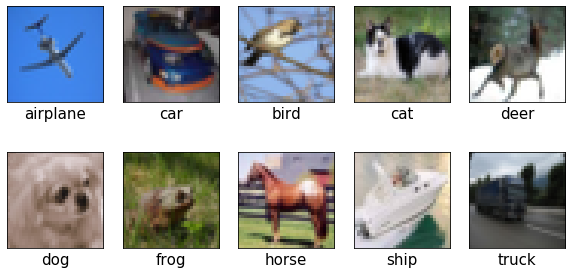

In [32]:
cifar10_display.__next__()

##### Load up the custom test set

I created a test set from images on the internet. Only problem is that it is quite small!

It can be seen that the images from the internet are much sharper as it appears the CIFAR-10 images have been smoothed.
I have added the option for a Gaussian blur to be applied to the custom test set in order to match the appearance of the CIFAR-10 images. Unfortunelty, size of the gaussian kernel is only matched by eye. My teacher did point me in the direction of a method of estimating the size of the kernel; which is very much on my to do list. 

Any how, it can be seen in the following testing that the

In [33]:
images = load_test_set(from_orig=0, save=0, blur=0)

Xtest, ytest = construct_XYTest(images)

idx = get_class_indices(ytest)

custom_display = display_random_images(Xtest, idx)

Here are my custom test images from the internet, you can remove the gaussian blur I added by setting 'blur' to zero
in the 'load_test_set' function. At the moment it will load preprocessed images but you can reprocess the originals by changing 'from_orig' to 1.

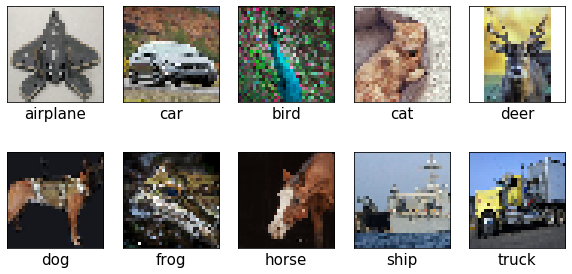

In [34]:
custom_display.__next__()

1 - Improved model without image augmentation 

2 - Improved model with image augmentation

3 - MobileNet model after only training output layer

4 - MobileNet model after trainging output and last convolutional layer

In [25]:
model = load_cnn(2) # Load a cnn if needed

In [26]:
eval_model(Xtest, ytest, model)

200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.7745572566986083, 0.585]

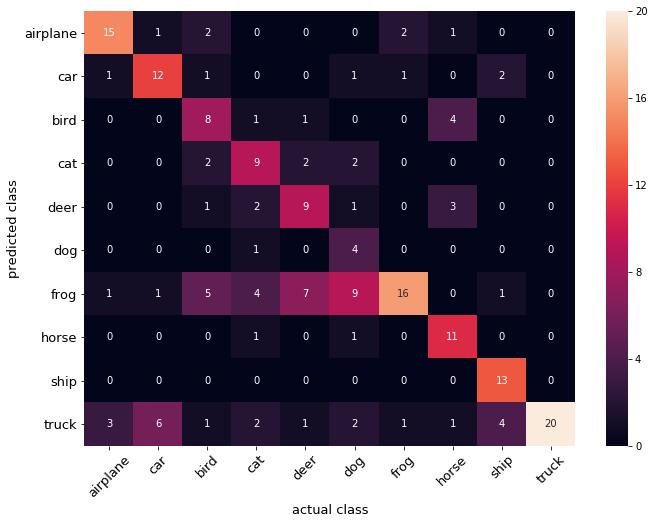

In [27]:
predictions = make_predictions(model, Xtest, ytest)

display_confusion(ytest, predictions)

Below you can view the misclassifications. This also allows us to make a sanity check with the confusion matrix results above.

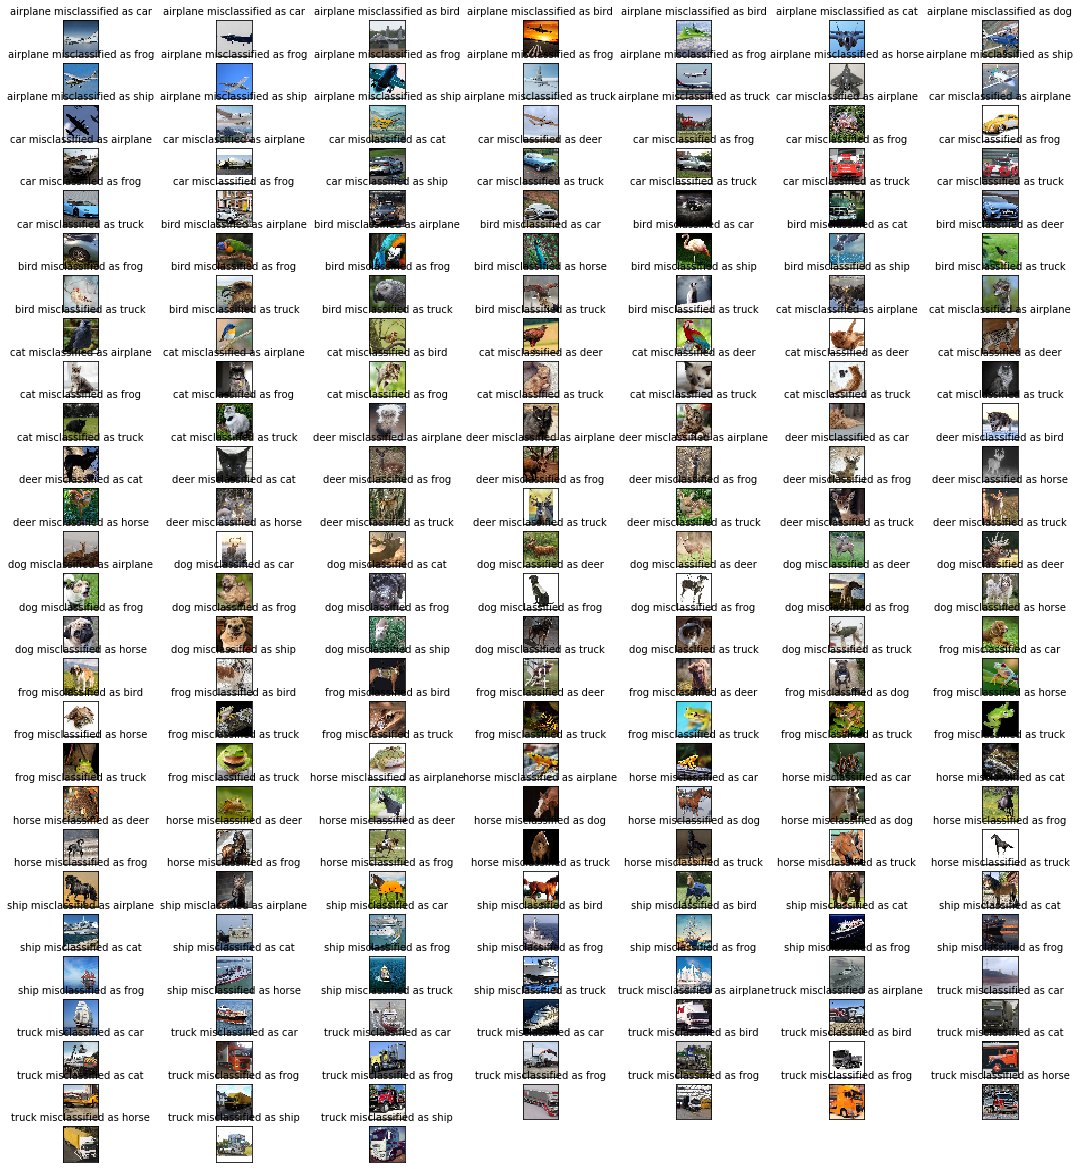

In [35]:
# indices and (true, false) labels
idx, labels = get_mistake_indices(ytest, predictions)

# misclassified samples
miss = Xtest[idx]
# image generator
display_mistakes(miss, labels)

# Visualize CNNs

Below we will use a couple of different methods to visualize what is happening in the internals of the CNNs

In [257]:
def display(X):
    
    plt.figure()
    
    for i in range(4):
        
        plt.subplot(2, 3, i + 1)
    
        plt.imshow(X[i])
        
        plt.tick_params(
                        axis='both',    # changes apply to the x-axis
                        which='both',   # both major and minor ticks are affected
                        bottom=False,   # ticks along the bottom edge are off
                        top=False,
                        left=False,      # ticks along the bottom edge are off
                        right=False,     # ticks along the top edge are off
                        labelbottom=False,
                        labelleft=False,
                        ) 
    
    plt.show()

#### Chosen images

We will see what happens when these 4 images pass through the CNN

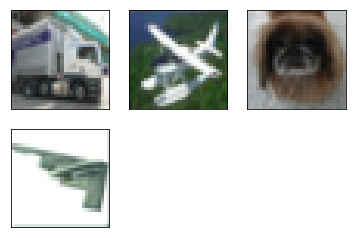

In [258]:
X = X_train[[39879, 2345, 999, 12345]]

display(X)

In [31]:
def get_vis_objects(model, layer_ids):
    
    '''
    creates a keras model object with multiple outputs
    Args:
        model     - model       - trained keras cnn object
        layer_ids - list of ints, indices of layers to be examined
    
    Returns:
        activation_model - new activation model
        layer_names      - list of strings of names of layers being examined as
                           they appear in model.layers
    
    '''

    layer_outputs = [layer.output for layer in np.array(model.layers)[layer_ids]]

    layer_names = [layer.name for layer in np.array(model.layers)[layer_ids]]

    # Extracts the outputs of the top 12 layers
    activation_model = Model(inputs=model.input,
                            outputs=layer_outputs) # Creates a model that will return these outputs
                                                         # given the model input
        
    return activation_model, layer_names

In [32]:
def display_activations(image, model, layer_names):
    '''
    This function will make and display a figure of activations in filters through different layers
    through the network. 
    
    Args:
        image       - array-like, 2D with 3 channels
        model       - trained keras cnn object
        layer_names - a list of strings of layer names which are to be examined
        
    Returns:
        displays a plot of stacked 2x8 tiled images, where tiles are the filters in the
        layer being examined. There will be a stack for each layer. Layers will be displayed 
        in order they appear in the network from input to output, top to bottom
    
    '''
    
    image = np.expand_dims(image, axis=0)
    
    # check model input and image dimensions match
    if not np.allclose(image.shape[1:], model.input_shape[1:]):
        
        img_rows = model.input_shape[1]
        img_cols = model.input_shape[2]
        
        image = np.array([cv2.resize(img, (img_rows, img_cols)) for img in image])
    
    activations =  model.predict(image)
    
    images_per_row = 8
    
    scale = 1. / 16
    
    plt.figure(figsize=(11, 8))
   
    for i, layer_name, layer_activation in zip(range(len(activations)), layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map

        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_rows = 2 #n_features // images_per_row # Tiles the activation channels in this matrix

        display_grid = np.zeros((size * n_rows, images_per_row * size))
        

        
        for row in range(n_rows): # Tiles each filter into a big horizontal grid
            for col in range(images_per_row):
                
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + col]
                
                channel_image = np.clip(channel_image, 0, 255)
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[row * size : (row + 1) * size, # Displays the grid
                             col * size : (col + 1) * size] = channel_image

        
        #plt.title(layer_name)
        plt.subplot(len(activations) + 1, 1, i + 1)
        plt.grid(False) # turns off matplotlib's auto gridlines
        plt.imshow(display_grid, aspect='equal', cmap='inferno')
        
        plt.tick_params(
                        axis='both',    # changes apply to the x-axis
                        which='both',   # both major and minor ticks are affected
                        bottom=False,   # ticks along the bottom edge are off
                        top=False,
                        left=False,      # ticks along the bottom edge are off
                        right=False,     # ticks along the top edge are off
                        labelbottom=False,
                        labelleft=False,
                        )
        
    plt.subplots_adjust(hspace=0.0)
    plt.show()

In [37]:
IMP2 = load_cnn(2) 
MNET2 = load_cnn(4)
models = [MNET2, IMP2]

In [186]:
# get indices of activation layers
print([i for i, layer in enumerate(IMP2.layers) if type(layer) ==  Activation])
print([i for i, layer in enumerate(MNET2.layers) if type(layer) ==  keras.layers.advanced_activations.ReLU])

[1, 3, 7, 9, 13, 15, 20]
[4, 7, 10, 14, 17, 20, 23, 27, 30, 33, 36, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 77, 80, 83, 86]


The last activation layer of IMP2 we have obtained is softmax so won't work... you have been warned!

In [260]:
# chosen activation layers
IMP2.chosen_layers = [3, 7, 13, 15] 
MNET2.chosen_layers = [7, 33, 55, 86]

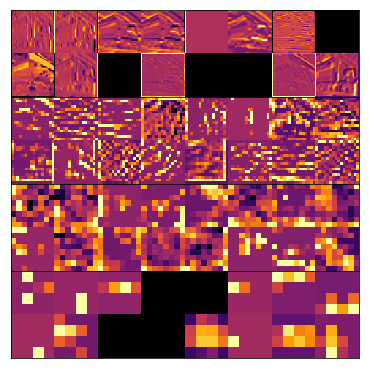

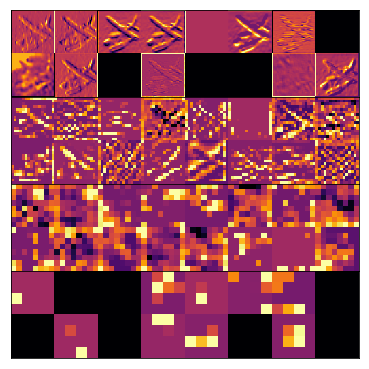

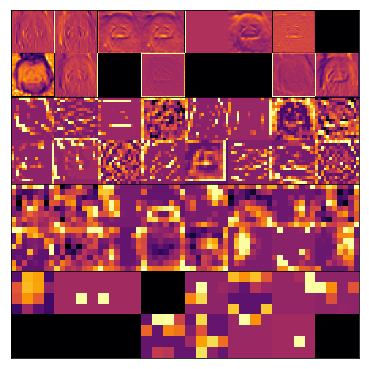

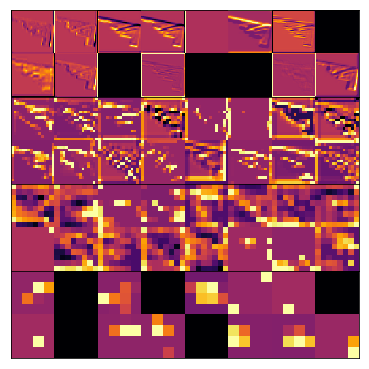

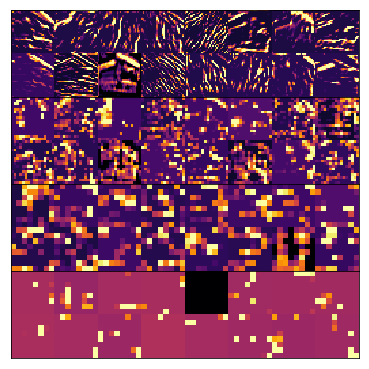

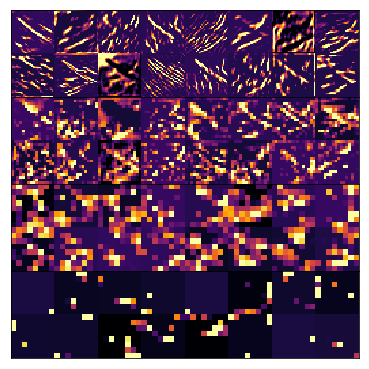

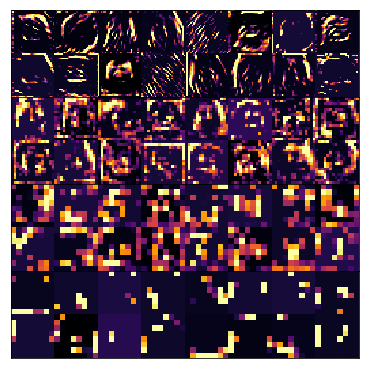

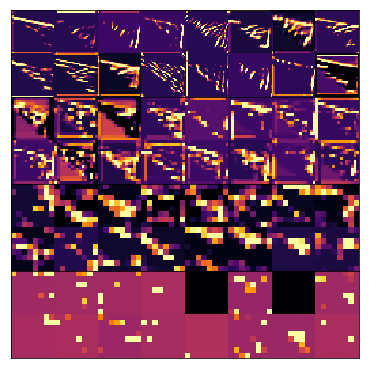

In [261]:
for model in models:
    activation_model, layer_names = get_vis_objects(model, model.chosen_layers)
    for image in X:
        display_activations(image, activation_model, layer_names)

For the next visualization I have followed this guide here:
    
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [35]:
from __future__ import print_function
import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K


def normalize(x):
    """utility function to normalize a tensor.
    # Arguments
        x: An input tensor.
    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):

    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.

    """

    # normalize tensor: center on 0., ensure std is 0.25

    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25


    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)


    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def process_image(x, former):

    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.
    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.

    """

    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()

def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None),
                    name='test'):

    """Visualizes the most relevant filters of one conv-layer in a certain model.


    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tuple[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.

    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):

        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns

            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.

        """

        s_time = time.time()



        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered

        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])

        else:

            loss = K.mean(layer_output[:, :, :, filter_index])
        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]


        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])



        # we start from a gray image with some random noise

        intermediate_dim = tuple(

            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(

                (1, 3, intermediate_dim[0], intermediate_dim[1]))

        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))

        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima

        for up in reversed(range(upscaling_steps)):

            # we run gradient ascent for e.g. 20 steps

            for _ in range(epochs):

                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them

                if loss_value <= K.epsilon():

                    return None

            # Calulate upscaled dimension

            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)

            # Upscale

            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))

            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image

        img = deprocess_image(input_img_data[0])
        e_time = time.time()

        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))

        return img, loss_value

    def _draw_filters(filters, n=5, name=name):

        """Draw the best filters in a nxn grid.
        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """

        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for

        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters

        for i in range(n):
            for j in range(n):               
                # Sometimes the filters get stuck at zero as described in a comment above.
                # These filters get disgarded which means we may not have enough 
                # To build the complete image so we use a try/except statement here.
                # It just means some tiles will be blank in the final image output.
                try:
                    img, _ = filters[i * n + j]
                    width_margin = (output_dim[0] + MARGIN) * i
                    height_margin = (output_dim[1] + MARGIN) * j
                    stitched_filters[
                        width_margin: width_margin + output_dim[0],
                        height_margin: height_margin + output_dim[1], :] = img
                except IndexError:
                    pass
                
        
        save_img(os.path.normpath('visualizations/{0:}_{1:}_{2:}x{2:}.png'.format(name, layer_name, n)), stitched_filters)

    # this is the placeholder for the input images

    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = filter_range[1]

    assert(filter_lower >= 0
           #and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))


    # iterate through each filter and generate its corresponding image

    processed_filters = []

    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)
        if img_loss is not None:
            processed_filters.append(img_loss)
    print('{} filter processed.'.format(len(processed_filters)))

    # Finally draw and store the best filters to disk

    _draw_filters(processed_filters, name=name)
    

In [314]:
# get indices of conv2D layers
print('IMP2 layers: ', [i for i, layer in enumerate(IMP2.layers) if type(layer) ==  Conv2D][1:-1])
print('MNET2 layers: ',[i for i, layer in enumerate(MNET2.layers) if type(layer) ==  Conv2D][1:-1])

IMP2 layers:  [2, 6, 8, 12]
MNET2 layers:  [8, 15, 21, 28, 34, 41, 47, 53, 59, 65, 71, 78]


Some of the layers have a large number of filters so it is computationally very expensive to visualize all layers and filters.

Take an index and model from above and enter them as arguments into 'visualize()'.

This will save an image in the visualizations folder containing a selection of the 'most interesting' images, which is based on loss (higher == more interesting).

In [34]:
def visualize(model, layer_index, name='IMP2', n_filters=256, outsize=412, upscaling_steps=9):
    '''
    A function to control visualize_layer function
    
    Args:
        model           - keras CNN object
        layer_index     - int, index of layer in model.layers, to be visualized
        name            - string, name of model for file name
        n_filters       - int, the number of filters to be processed
        outsize         - int, dimensions of a single filter image will be outsizexoutsize
        upscaling_steps - int, images require upscaling from model input size, this will be
                          done by size * steps ** upscaling_steps
    Returns:
        saves an image in folder 'visualizations' relative to this one
        
        '''
    # set layers to trainable - just incase
    for layer in model.layers:
        layer.trainable = True

    # calculate what power to raise scale by each step 'upscaling_factor'
    input_scale= model.input_shape[1]
    upscaling_factor = (outsize / model.input_shape[1] ) ** (1 / upscaling_steps)
    
    # number of filters to process
    layer =  model.layers[layer_index]
    # check in number of filters is valid
    if layer.output_shape[-1] > n_filters:
        filter_range = (0, n_filters)
    else:
        filter_range = (0, layer.output_shape[-1])

    visualize_layer(
                    model, 
                    layer.name, 
                    filter_range=filter_range, 
                    name=name,
                    upscaling_steps=upscaling_steps,
                    upscaling_factor=upscaling_factor, 
                    output_dim = (outsize, outsize),
                    )

Create Google Deep Dream style images by running this cell

In [39]:
#visualize(MNET2, 47, name='MNET2', n_filters=64)
visualize(IMP2, 6, name='IMP2', n_filters=128)

Compute filters 0 to 64
Costs of filter   3:   288 ( 1.63s )
Costs of filter  22:   224 ( 1.32s )
Costs of filter  30:   146 ( 1.38s )
Costs of filter  32:   249 ( 1.28s )
Costs of filter  34:   152 ( 1.19s )
Costs of filter  36:   285 ( 1.33s )
Costs of filter  40:   172 ( 1.61s )
Costs of filter  46:   236 ( 1.35s )
Costs of filter  47:   185 ( 1.31s )
Costs of filter  49:    77 ( 1.37s )
Costs of filter  51:   149 ( 1.40s )
Costs of filter  55:   171 ( 1.45s )
Costs of filter  58:   104 ( 1.30s )
13 filter processed.
